In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
import numpy as np
import copy
import random

In [13]:
def chinese_postman(graph):
    odd_nodes = [node for node, degree in graph.degree() if degree % 2 != 0]
    if len(odd_nodes) == 0:
        return nx.eulerian_circuit(graph)
    elif len(odd_nodes) == 2:
        u, v = odd_nodes
        eulerian_trail = list(nx.eulerian_path(graph, source=u))
        return eulerian_trail

    min_weight_matching = nx.max_weight_matching(graph)
    augmented_graph = graph.copy()
    for u, v in min_weight_matching:
        augmented_graph.add_edge(u, v, weight=0)  # Add zero-weight edges for matched edges

    try:
        eulerian_circuit = list(nx.eulerian_circuit(augmented_graph))
    except nx.NetworkXError:
        eulerian_circuit = list(nx.eulerian_circuit(nx.eulerize(augmented_graph)))

    # Shortcut repeated vertices in the Eulerian circuit
    shortcut_circuit = []
    for u, v in eulerian_circuit:
        if u != v:
            shortcut_circuit.append((u, v))
    return shortcut_circuit

In [14]:
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 4), (3, 4)])
solution = chinese_postman(G)
print("Chinese Postman Circuit:", solution)

Chinese Postman Circuit: [(2, 1), (1, 3), (3, 2), (2, 4), (4, 3)]


In [15]:
def visualize_graph(G):
    pos = nx.spring_layout(G)  # You can use other layouts as well

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='black', width=1.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)

    # Draw node labels
    node_labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    plt.title("Graph Visualization")
    plt.show()

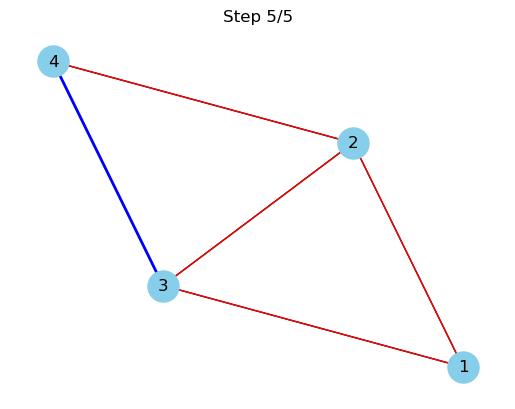

In [16]:
pos = nx.spring_layout(G)  # You can use any layout algorithm here

# Create a figure and axis
fig, ax = plt.subplots()

traversed_edges = set()

# Define an update function for the animation
def update(frame):
    ax.clear()
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, ax=ax)
    
    # Draw traversed edges in red, others in black
    for edge in solution[:frame+1]:
        if edge not in traversed_edges:
            nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color='b', width=2.0, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color='r', width=1.0, ax=ax)
        traversed_edges.add(edge)
    
    ax.set_title(f'Step {frame+1}/{len(solution)}')

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(solution), interval=1000, repeat=False)
anim.save("cpp.gif")
# Display the animation
plt.show()

In [19]:
def generate_sf_graph(n):
    G = nx.scale_free_graph(n=n,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    components = list(nx.connected_components(G))
    while len(components) > 1:
        G.add_edge(components[0].pop(), components[1].pop())
        components = list(nx.connected_components(G))
    return G

In [20]:
def back_step_reduction(graph):
    visited_edges = set()
    walked_edges = []
    nodes = list(graph.nodes())
    
    current_node = random.choice(nodes)
    while len(visited_edges) < graph.number_of_edges():
        neighbors = list(graph.neighbors(current_node))
        weights = [graph[current_node][neighbor].get('weight', 1) for neighbor in neighbors]
        if len(weights) == 0:
            print("some fuckery")
            visualize_graph(graph)

        # Normalize weights to create probabilities
        try:
            probabilities = [weight / sum(weights) for weight in weights]
        except:
            print(weights)
            return
            

        next_node = random.choices(neighbors, weights=probabilities)[0]
        edge = (min(current_node, next_node), max(current_node, next_node))

        visited_edges.add(edge)
        walked_edges.append(edge)
        #print(f"Visited edge: {edge}")
        
        graph[current_node][next_node]['weight'] = np.sqrt(graph[current_node][next_node]['weight'])
        
        
        current_node = next_node

    return walked_edges

In [21]:
def add_weights_to_edges_from_dict(graph, weights_dict):
    for edge, weight in weights_dict.items():
        if graph.has_edge(*edge):
            graph[edge[0]][edge[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        elif graph.has_edge(*reversed(edge)):
            graph[reversed(edge)[0]][reversed(edge)[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        else:
            print(f"Edge {edge} not found in the graph.")

In [29]:
UN_walks = []
CPP_walks = []
edge_count = []

for i in range(50,100):
    tmp_un = []
    tmp_cpp = []
    tmp_e = []
    
    for j in range(10):
        G = generate_sf_graph(i)
        tmp_e.append(G.number_of_edges())
        L_G = nx.line_graph(G)
        UN = vertex_dict = {vertex: 0.001 for vertex in L_G.nodes()}

        U_G = copy.deepcopy(G)
        add_weights_to_edges_from_dict(U_G,UN)
        u_tmp =[]
        for k in range(i):
            tmp=copy.deepcopy(U_G)
            u_tmp.append(len(back_step_reduction(tmp)))
        cpp_tmp = []
        tmp=copy.deepcopy(G)
        cpp_tmp.append(len(chinese_postman(tmp)))
        tmp_un.append(u_tmp)
        tmp_cpp.append(cpp_tmp)
    edge_count.append(tmp_e)
    
    UN_walks.append(tmp_un)
    CPP_walks.append(tmp_cpp)

In [63]:
np_u = []
np_cpp = []
for i in range(len(UN_walks)):    
    tmp = np.concatenate(UN_walks[i])
    tmp =np.array(tmp)
    tmp = np.sort(tmp)[:500]
    np_u.append(tmp)

tmp_cpp=[]

for i in range(len(CPP_walks)):
    tmp = np.concatenate(CPP_walks[i])
    tmp_cpp.append(tmp)
print(len(np_u[0]))
print(len(np_u[1]))
np_cpp = np.array(tmp_cpp)
np_e = np.array(edge_count)

500
500


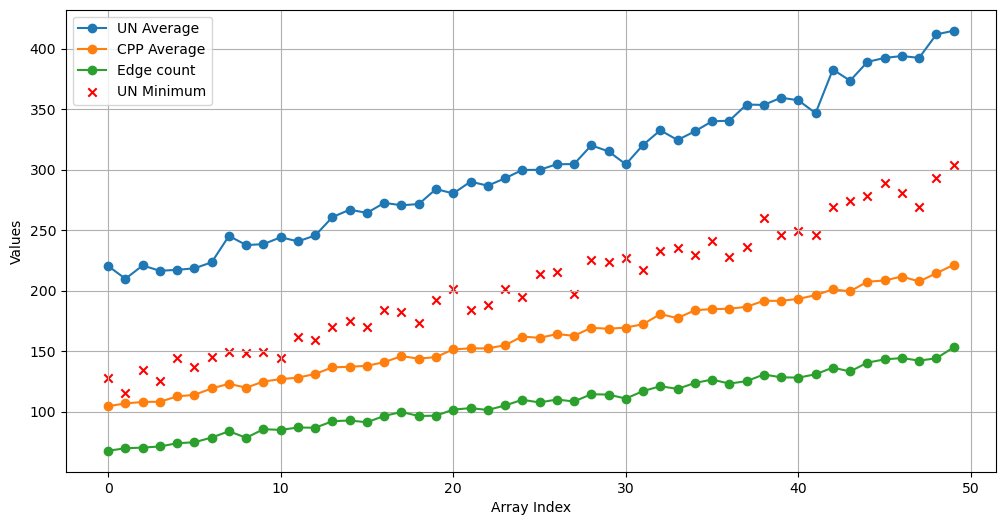

In [64]:



avg_r = np.mean(np_u,axis=1)
avg_p = np.mean(np_cpp,axis=1)

min_r = np.min(np_u,axis=1)

np_e = np.mean(np_e,axis=1)

plt.figure(figsize=(12, 6))

plt.plot( avg_r, label='UN Average', marker='o')
plt.plot( avg_p, label='CPP Average', marker='o')
plt.plot( np_e, label='Edge count Average', marker='o')

# Plot minimums
plt.scatter(range(len(min_r)), min_r, color='red', label='UN Minimum', marker='x')

plt.xlabel('Array Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
